### *Use this one simple trick to get to the top of the leaderboard - Grandmasters hate him!*

Here's quite a high-level EDA - since the data is so huge, we want to get a better understanding of what we actually have.

If this EDA helps you, make sure to leave an upvote to motivate me to make more! :)

First off: What files do we have?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

p = sns.color_palette()

print('# File sizes')
for f in os.listdir('data'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('data/' + f) / 1000000, 2)) + 'MB')

# File sizes
page_views_sample.csv         454.35MB
documents_meta.csv            89.38MB
documents_categories.csv      118.02MB
events.csv                    1208.55MB
clicks_test.csv               506.95MB
promoted_content.csv          13.89MB
documents_topics.csv          339.47MB
documents_entities.csv        324.1MB
sample_submission.csv         273.14MB
clicks_train.csv              1486.73MB


Wow, that's a lot of data! Let's start off by looking at the clicks_train.csv and clicks_test.csv files, as these contain the main things we need.

Each display has a certain number of adverts. Let's look at the distribution of these advert counts, and see if they are consistent between train and test.

In [2]:
df_train = pd.read_csv('data/clicks_train.csv')
df_test = pd.read_csv('data/clicks_test.csv')

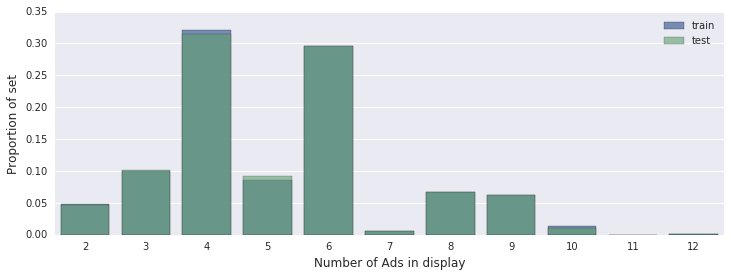

In [3]:
sizes_train = df_train.groupby('display_id')['ad_id'].count().value_counts()
sizes_test = df_test.groupby('display_id')['ad_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

This looks like a perfect split to me! So we can assume the distribution to be the same within the sets - no weird trickery going on here.

What about adverts? How many adverts are there that are very often used, and how many are rare?

Ads that appear less than 2 times: 22.69%
Ads that appear less than 10 times: 61.74%
Ads that appear less than 50 times: 86.93%
Ads that appear less than 100 times: 91.04%
Ads that appear less than 1000 times: 97.45%


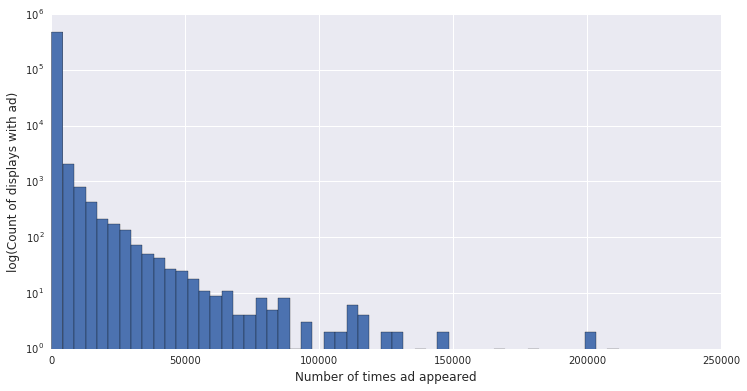

In [4]:
ad_usage_train = df_train.groupby('ad_id')['ad_id'].count()

for i in [2, 10, 50, 100, 1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=50, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

Here we can see that a **huge** number of ads appear just a few times in the training set (so much that we have to use a log graph to show it), with two-thirds having less than 10 appearances. This shows us that we have to be able to predict whether someone will click on an ad not just based on the past data of that specific ad, but also by linking it to other adverts.

I think this is the underlying challenge that Outbrain has for us.

Before we move on, let's check how many ads in the test set are not in the training set.

In [5]:
ad_prop = len(set(df_test.ad_id.unique()).intersection(df_train.ad_id.unique())) / len(df_test.ad_id.unique())
print('Proportion of test ads in test that are in training: {}%'.format(round(ad_prop * 100, 2)))

Proportion of test ads in test that are in training: 82.87%


This number is a little more reasonable, with 88% of ads appearing in both sets.

## Events

Let's move on to the events file. I'm not going to cover the [timestamp](https://www.kaggle.com/joconnor/outbrain-click-prediction/date-exploration-and-train-test-split) or the [location](https://www.kaggle.com/andreyg/outbrain-click-prediction/explore-user-base-by-geo), since these have already been beautifully explored - you can click the links to view those EDAs.

In [6]:
try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

events = pd.read_csv('../input/events.csv')
print('Shape:', events.shape)
print('Columns', events.columns.tolist())
events.head()

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (23120126, 6)
Columns ['display_id', 'uuid', 'document_id', 'timestamp', 'platform', 'geo_location']


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [7]:
plat = events.platform.value_counts()

print(plat)
print('\nUnique values of platform:', events.platform.unique())

2     10684579
1      8747280
3      3032907
2       291699
1       279988
3        83668
\N           5
Name: platform, dtype: int64

Unique values of platform: [3 2 1 '2' '1' '3' '\\N']


This is very interesting, notice how 1, 2 and 3 are repeated twice in the platform, once as floats, and once as strings.

This might become useful in the future (leak? :P) - but for now, I'm just going to treat them as the same thing.

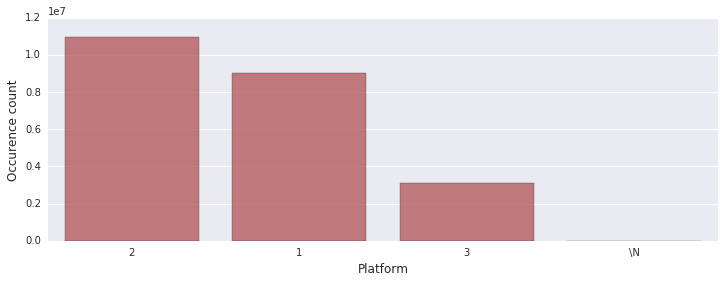

In [8]:
events.platform = events.platform.astype(str)
plat = events.platform.value_counts()

plt.figure(figsize=(12,4))
sns.barplot(plat.index, plat.values, alpha=0.8, color=p[2])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence count', fontsize=12)

It's still unclear what the platform means, but it's possible that it's things like computers, phones, tablets etc. 

The `\\N`s and string numbers may have come from the way that a file was parsed while creating the dataset, but it's still a mystery. If anyone has any other ideas, I'd love to hear them!

Let's do some quick analysis on the UUID next.

uuid
ef7761dd22277c    38
45d23867dbe3b3    38
c0bd502c7a479f    42
2759b057797f02    46
b88553e3a2aa29    49
Name: uuid, dtype: int64
Users that appear less than 2 times: 88.42%
Users that appear less than 5 times: 99.51%
Users that appear less than 10 times: 99.96%


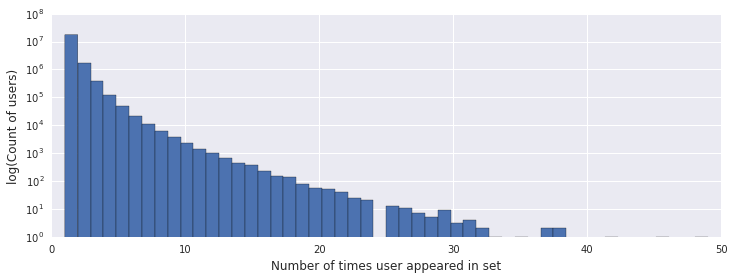

In [9]:
uuid_counts = events.groupby('uuid')['uuid'].count().sort_values()

print(uuid_counts.tail())

for i in [2, 5, 10]:
    print('Users that appear less than {} times: {}%'.format(i, round((uuid_counts < i).mean() * 100, 2)))
    
plt.figure(figsize=(12, 4))
plt.hist(uuid_counts.values, bins=50, log=True)
plt.xlabel('Number of times user appeared in set', fontsize=12)
plt.ylabel('log(Count of users)', fontsize=12)
plt.show()

Here we see a distribution much like the ad ids, with 88% of users being unique - there will be little scope of building user-based recommendation profiles here.

I'd love to look at things like whether the same user ever clicks on the same ad twice, or whether a user transverses the training & testing set, but we're limited by the Kernels memory limit here :(

## Categories

Outbrain has some content classification algorithms, and they have provided us with the output from these classifications. Let's take a look at some of the most popular classifications.

In [10]:
try:del events
except:pass;gc.collect()

topics = pd.read_csv('../input/documents_topics.csv')
print('Columns:',topics.columns.tolist())
print('Number of unique topics:', len(topics.topic_id.unique()))

topics.head()

Columns: ['document_id', 'topic_id', 'confidence_level']
Number of unique topics: 300


,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


Number of topics that appear more than 10000 times: 201
Number of topics that appear more than 50000 times: 86
Number of topics that appear more than 100000 times: 22
Number of topics that appear more than 200000 times: 3


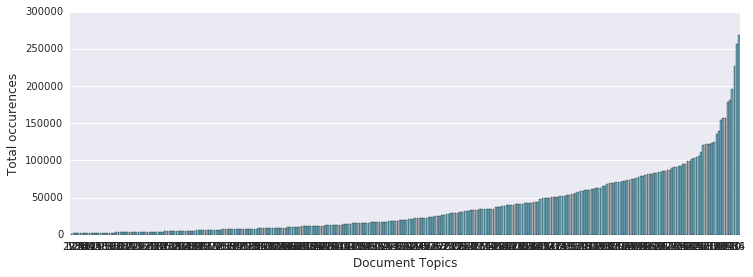

In [11]:
topic_ids = topics.groupby('topic_id')['confidence_level'].count().sort_values()

for i in [10000, 50000, 100000, 200000]:
    print('Number of topics that appear more than {} times: {}'
          .format(i, (topic_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(topic_ids.index, topic_ids.values, order=topic_ids.index, alpha=1, color=p[5])
plt.xlabel('Document Topics', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()

Columns: ['document_id', 'category_id', 'confidence_level']
Number of unique categories: 97
Number of categories that appear more than 1000 times: 88
Number of categories that appear more than 10000 times: 65
Number of categories that appear more than 50000 times: 35
Number of categories that appear more than 100000 times: 15


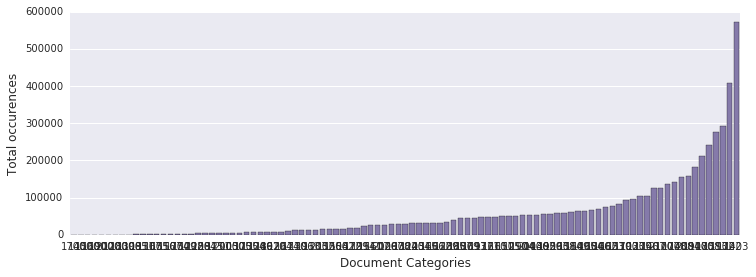

In [12]:
cat = pd.read_csv('../input/documents_categories.csv')
print('Columns:', cat.columns.tolist())
print('Number of unique categories:', len(cat.category_id.unique()))

cat_ids = cat.groupby('category_id')['confidence_level'].count().sort_values()

for i in [1000, 10000, 50000, 100000]:
    print('Number of categories that appear more than {} times: {}'
          .format(i, (cat_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(cat_ids.index, cat_ids.values, order=cat_ids.index, alpha=1, color=p[3])
plt.xlabel('Document Categories', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()

That's it for today, folks!

Hopefully this helps you think of some ideas - I'll continue updating this as I do more exploration over the next few days.

Once again, please upvote if this was useful :P